# GM-VAE for SMBA

In [1]:
num_components=3

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
from metrics.Metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [4]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [5]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [6]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [7]:
chunks = smb_onehot

## Input Parameters

In [8]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=200,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [9]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [15]:
with open('../../1906-pcgml/pcgml-gmmVae-exp/data/smba_level_idx_per_chunk.json', 'r') as json_f:
    level_idxs = np.array(json.load(json_f))

In [16]:
np.bincount(level_idxs), np.unique(level_idxs)

(array([ 315, 1829,  554]), array([0, 1, 2]))

In [17]:
frequency = np.bincount(level_idxs)
1 / frequency[level_idxs]

array([0.00054675, 0.00054675, 0.00054675, ..., 0.00054675, 0.00054675,
       0.00054675])

In [18]:
from torch.utils.data import TensorDataset, DataLoader

In [19]:
assert args.train_proportion != 1

In [20]:
valid_indices = np.random.randint(len(chunks), size=500)
train_chunks, valid_chunks = chunks, chunks[valid_indices]
train_labels, valid_labels = level_idxs, level_idxs[valid_indices]

train_ds = TensorDataset(torch.from_numpy(train_chunks).float(), torch.from_numpy(train_labels).long())
valid_ds = TensorDataset(torch.from_numpy(valid_chunks).float(), torch.from_numpy(valid_labels).long())

In [21]:
train_sampler = WeightedRandomSampler(1 / frequency[level_idxs], num_samples=len(train_chunks), replacement=True)

train_dl = DataLoader(train_ds, batch_size=64, sampler=train_sampler)
# train_dl = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=args.batch_size_val, shuffle=False)

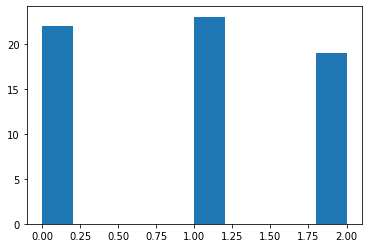

In [348]:
plt.hist(next(iter(train_dl))[1].numpy())
plt.show()

## Train Model

In [10]:
# Model Initialization
gmvae = GMVAE(args)

In [352]:
history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 200) Train_Loss: 496.746; Val_Loss: 247.224   Train_ACC: 34.359; Val_ACC: 65.600   Train_NMI: 0.134; Val_NMI: 1.821
(Epoch 2 / 200) Train_Loss: 278.785; Val_Loss: 238.445   Train_ACC: 44.589; Val_ACC: 70.800   Train_NMI: 15.176; Val_NMI: 22.366
(Epoch 3 / 200) Train_Loss: 270.982; Val_Loss: 227.984   Train_ACC: 60.007; Val_ACC: 70.800   Train_NMI: 17.925; Val_NMI: 19.911
(Epoch 4 / 200) Train_Loss: 255.314; Val_Loss: 225.287   Train_ACC: 63.973; Val_ACC: 76.200   Train_NMI: 37.608; Val_NMI: 56.799
(Epoch 5 / 200) Train_Loss: 247.926; Val_Loss: 217.254   Train_ACC: 66.642; Val_ACC: 82.800   Train_NMI: 59.204; Val_NMI: 55.919
(Epoch 6 / 200) Train_Loss: 238.192; Val_Loss: 207.286   Train_ACC: 83.655; Val_ACC: 87.400   Train_NMI: 61.189; Val_NMI: 60.965
(Epoch 7 / 200) Train_Loss: 231.214; Val_Loss: 202.355   Train_ACC: 86.620; Val_ACC: 91.200   Train_NMI: 64.184; Val_NMI: 67.971
(Epoch 8 / 200) Train_Loss: 226.275; Val_Loss: 198.196   Train_ACC: 87.139; Val_ACC: 92.000   Train

(Epoch 65 / 200) Train_Loss: 129.054; Val_Loss: 129.474   Train_ACC: 87.769; Val_ACC: 94.200   Train_NMI: 62.702; Val_NMI: 74.171
(Epoch 66 / 200) Train_Loss: 126.475; Val_Loss: 128.613   Train_ACC: 86.805; Val_ACC: 94.400   Train_NMI: 62.027; Val_NMI: 74.330
(Epoch 67 / 200) Train_Loss: 127.399; Val_Loss: 128.907   Train_ACC: 87.769; Val_ACC: 89.000   Train_NMI: 62.935; Val_NMI: 63.570
(Epoch 68 / 200) Train_Loss: 125.956; Val_Loss: 128.037   Train_ACC: 87.027; Val_ACC: 95.000   Train_NMI: 61.433; Val_NMI: 76.521
(Epoch 69 / 200) Train_Loss: 123.117; Val_Loss: 126.200   Train_ACC: 88.028; Val_ACC: 95.000   Train_NMI: 63.598; Val_NMI: 76.166
(Epoch 70 / 200) Train_Loss: 122.735; Val_Loss: 128.011   Train_ACC: 87.546; Val_ACC: 94.600   Train_NMI: 62.844; Val_NMI: 74.673
(Epoch 71 / 200) Train_Loss: 118.702; Val_Loss: 125.910   Train_ACC: 85.730; Val_ACC: 95.000   Train_NMI: 59.338; Val_NMI: 76.316
(Epoch 72 / 200) Train_Loss: 119.783; Val_Loss: 124.749   Train_ACC: 88.695; Val_ACC: 94.6

KeyboardInterrupt: 

In [383]:
torch.save(gmvae.network.state_dict(), 'smba_gmvae_balanced.pth')

In [11]:
gmvae.network.load_state_dict(torch.load('smba_gmvae_balanced.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Image Reconstruction

In [18]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [19]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [20]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [21]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [22]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [23]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

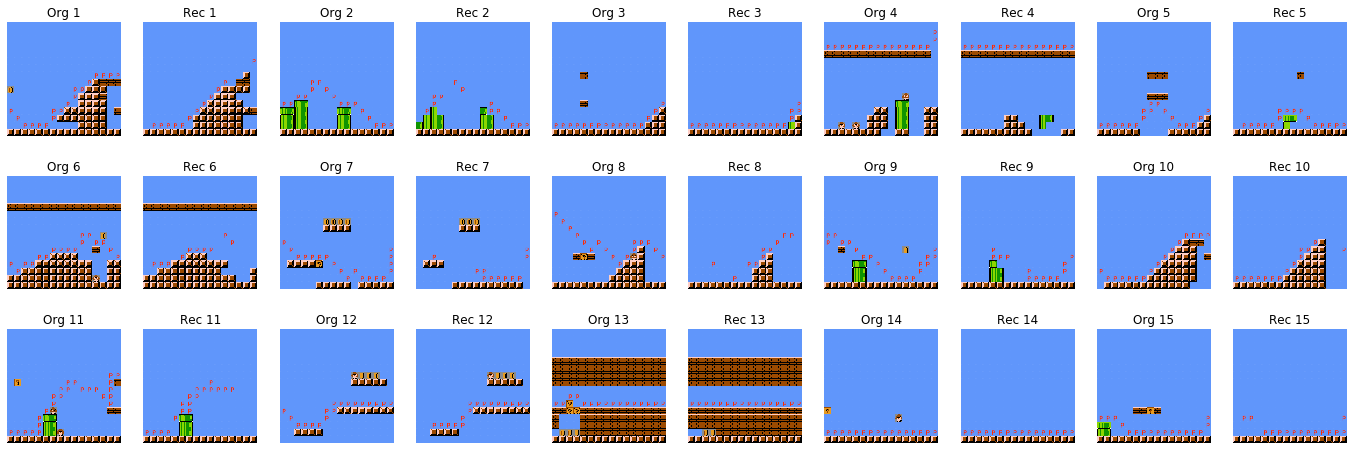

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

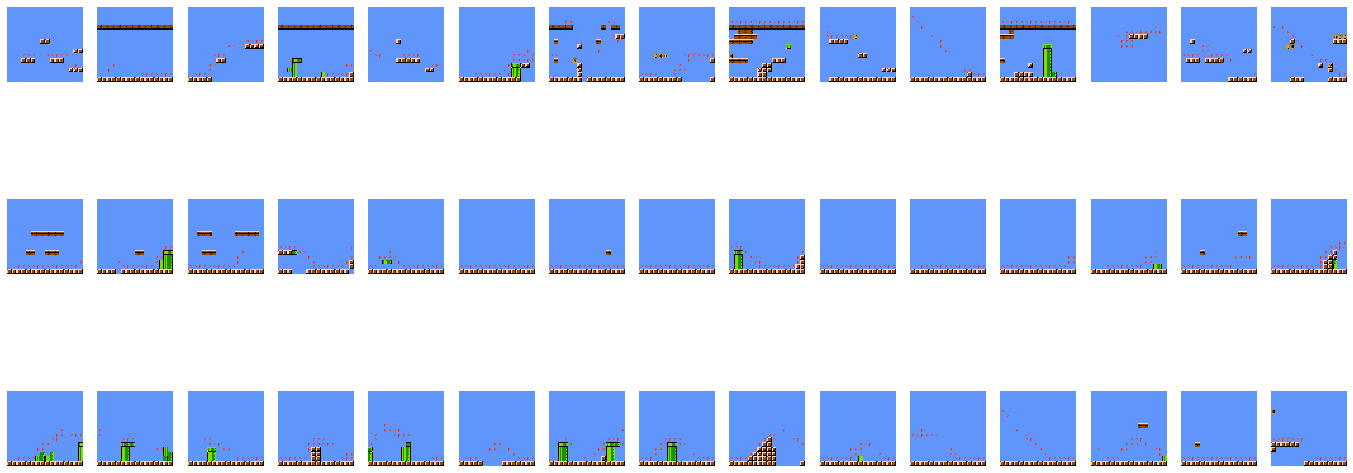

In [81]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,10])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [26]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [27]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [28]:
generated_int.shape

(9999, 16, 16)

In [29]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations_2_to_7/smba_gmvae_{num_components}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [22]:
test_features, test_labels = gmvae.latent_features(DataLoader(train_ds, batch_size=64, shuffle=False), return_learned_labels=True)

In [83]:
with open('../../1906-pcgml/pcgml-gmmVae-exp/data/smba_level_idx_per_chunk.json', 'r') as json_f:
    level_idxs = np.array(json.load(json_f))

In [84]:
np.random.seed(42)

type1 = np.where(level_idxs == 0)[0]
type2 = np.where(level_idxs == 1)[0]
type3 = np.where(level_idxs == 2)[0]

random_idxs_1 = np.random.choice(type1, size=333, replace=True)
random_idxs_2 = np.random.choice(type2, size=333, replace=True)
random_idxs_3 = np.random.choice(type3, size=333, replace=True)
random_indices = np.concatenate([random_idxs_1, random_idxs_2, random_idxs_3])
#random_indices = np.random.randint(len(test_features), size=1000)

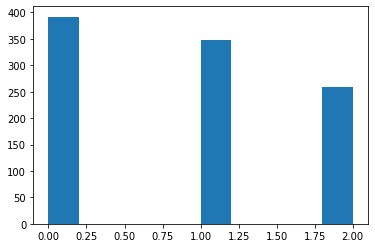

In [85]:
plt.hist(test_labels[random_indices])
plt.show()

In [90]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

np.random.seed(10)
tsne_features = TSNE(n_components=2).fit_transform(test_features[random_indices])

In [91]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

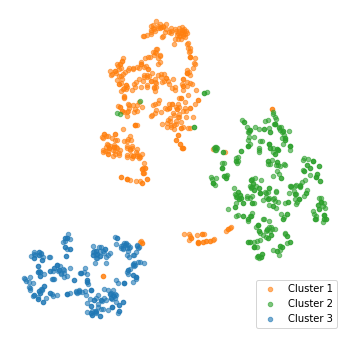

In [103]:
plt.figure(figsize=(6, 6))

colors = ['#ff7f0e', '#2ca02c', '#1f77b4']

for i in range(3):
    
    plt.scatter(
        tsne_features[test_labels[random_indices] == i][X_], 
        tsne_features[test_labels[random_indices] == i][Y_],
        s=20, alpha=0.6,
        label=f'Cluster {i+1}',
        color=colors[i]
    )
    
plt.axis('off')
plt.legend(loc='lower right')
plt.savefig('smba_gmvae_arrangement_cluster.png', dpi=300)

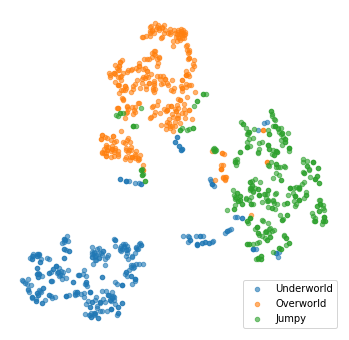

In [102]:
plt.figure(figsize=(6, 6))

level_types = ['Underworld', 'Overworld', 'Jumpy']

for i in range(3):

    plt.scatter(
        tsne_features[level_idxs[random_indices] == i][X_], 
        tsne_features[level_idxs[random_indices] == i][Y_],  
        label=level_types[i],
        s=20, alpha=0.6
    )
            
plt.axis('off')
plt.legend(loc='lower right')
plt.savefig('smba_gmvae_arrangement_label.png', dpi=300)

In [397]:
metrics = Metrics()
metrics.cluster_acc(test_labels[:first_n], level_idxs[:first_n])

0.934